# Imports + Basic Setup

In [4]:
# Imports & basic setup
import joblib
import os
import tempfile
import time
import warnings
import pickle
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import LinearSVR
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Flatten


In [5]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU detected for TensorFlow.")

        # Test if XGBoost supports GPU
        try:
            _ = XGBRegressor(tree_method='gpu_hist')
            XGBOOST_TREE_METHOD = 'gpu_hist'
            print("XGBoost GPU mode enabled.")
        except:
            XGBOOST_TREE_METHOD = 'auto'
            print("XGBoost GPU not supported → using CPU mode.")

    except Exception as e:
        print("TensorFlow GPU init failed:", e)
        XGBOOST_TREE_METHOD = 'auto'
else:
    print("No GPU detected → CPU only.")
    XGBOOST_TREE_METHOD = 'auto'


GPU detected for TensorFlow.
XGBoost GPU mode enabled.


In [6]:
df=pd.read_csv("merged_energy_weather_data.csv")

In [7]:
df['datetime'] = pd.to_datetime(df['datetime'], utc=True).dt.tz_convert("Europe/London")
df = df.sort_values('datetime').reset_index(drop=True)

df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['year'] = df['datetime'].dt.year
#weekday 0=mon 6=sun
df['weekday'] = df['datetime'].dt.weekday
#weekend flag ie 1=sat/sun 0=mon-fri
df['is_weekend']=df['weekday'].apply(lambda x: 1 if x>=5 else 0)


# EDA

In [8]:
# 1. check missing values

In [9]:
df.isnull().sum()

,0
SETTLEMENT_DATE,0
SETTLEMENT_PERIOD,0
ND,0
TSD,0
ENGLAND_WALES_DEMAND,0
EMBEDDED_WIND_GENERATION,0
EMBEDDED_WIND_CAPACITY,0
EMBEDDED_SOLAR_GENERATION,0
EMBEDDED_SOLAR_CAPACITY,0
NON_BM_STOR,0


In [10]:
# 2. check duplicates

In [11]:
df.duplicated().sum()

np.int64(0)

In [12]:
# Select only rows with duplicated datetime
duplicate_rows = df[df['datetime'].duplicated(keep=False)]

#Duplicate SETTLEMENT_DATE and datetime
duplicate_rows[['SETTLEMENT_DATE', 'datetime']]

,SETTLEMENT_DATE,datetime


In [13]:
# 3. check for impossible values eg negative energy demand or solar/wind generation
#negative value for demand
demand_cols=["ND","TSD","ENGLAND_WALES_DEMAND","EMBEDDED_WIND_GENERATION","EMBEDDED_WIND_CAPACITY","EMBEDDED_SOLAR_GENERATION","EMBEDDED_SOLAR_CAPACITY"]

neg_demand=df[(df[demand_cols]<0).any(axis=1)]
print(f"Negative:          {len(neg_demand)} rows")

Negative:          0 rows


In [14]:
#wind generation > capacity
exceed_wind=df[df["EMBEDDED_WIND_GENERATION"] > df["EMBEDDED_WIND_CAPACITY"]]

#solar generation> capacity
exceed_solar = df[df["EMBEDDED_SOLAR_GENERATION"] > df["EMBEDDED_SOLAR_CAPACITY"]]

print(f"Exceed Wind:          {len(exceed_wind)} rows")

print(f"Exceed Solar:          {len(exceed_solar)} rows")

Exceed Wind:          0 rows
Exceed Solar:          0 rows


In [15]:
# Temperature spikes
temp_spikes = df[(df['temperature_2m'] < -30) | (df['temperature_2m'] > 50)]

# Wind spikes
wind_speed_spikes = df[(df['wind_speed_10m'] < 0) | (df['wind_speed_10m'] > 60)]

#Huminity
humidity_invalid = df[(df['relativehumidity_2m'] < 0) | (df['relativehumidity_2m'] > 100)]

# pressure
pressure_invalid = df[(df['pressure_msl'] < 800) | (df['pressure_msl'] > 1100)]

# wind direction
wind_direction_invalid = df[(df['wind_direction_10m'] < 0) | (df['wind_direction_10m'] > 360)]

# precipitation
precipitation_negative = df[df['precipitation'] < 0]

print(f"Temperature unrealistic:          {len(temp_spikes)} rows")
print(f"Wind speed unrealistic:           {len(wind_speed_spikes)} rows")
print(f"Humidity invalid:                 {len(humidity_invalid)} rows")
print(f"Pressure invalid:                 {len(pressure_invalid)} rows")
print(f"Wind direction invalid:           {len(wind_direction_invalid)} rows")
print(f"Negative precipitation:           {len(precipitation_negative)} rows")

Temperature unrealistic:          0 rows
Wind speed unrealistic:           0 rows
Humidity invalid:                 0 rows
Pressure invalid:                 0 rows
Wind direction invalid:           0 rows
Negative precipitation:           0 rows


In [16]:
#mismatch date and time
df['SETTLEMENT_DATE'] = (
    pd.to_datetime(df['SETTLEMENT_DATE'], utc=True)
      .dt.tz_convert("Europe/London")
)

settlement_dates = df['SETTLEMENT_DATE'].dt.date
datetime_dates   = df['datetime'].dt.date

mismatch = df[settlement_dates != datetime_dates]

print(mismatch[['SETTLEMENT_DATE', 'datetime']])

Empty DataFrame
Columns: [SETTLEMENT_DATE, datetime]
Index: []


In [17]:
# 4. plot full time series
# line chart of demand over full time period
# ENGLAND_WALES_DEMAND vs datetime
# to identify overall trends(is demand rising/falling), seasonal patterns(daily/weekly/annual cycles), anomalies(spikes/drops)

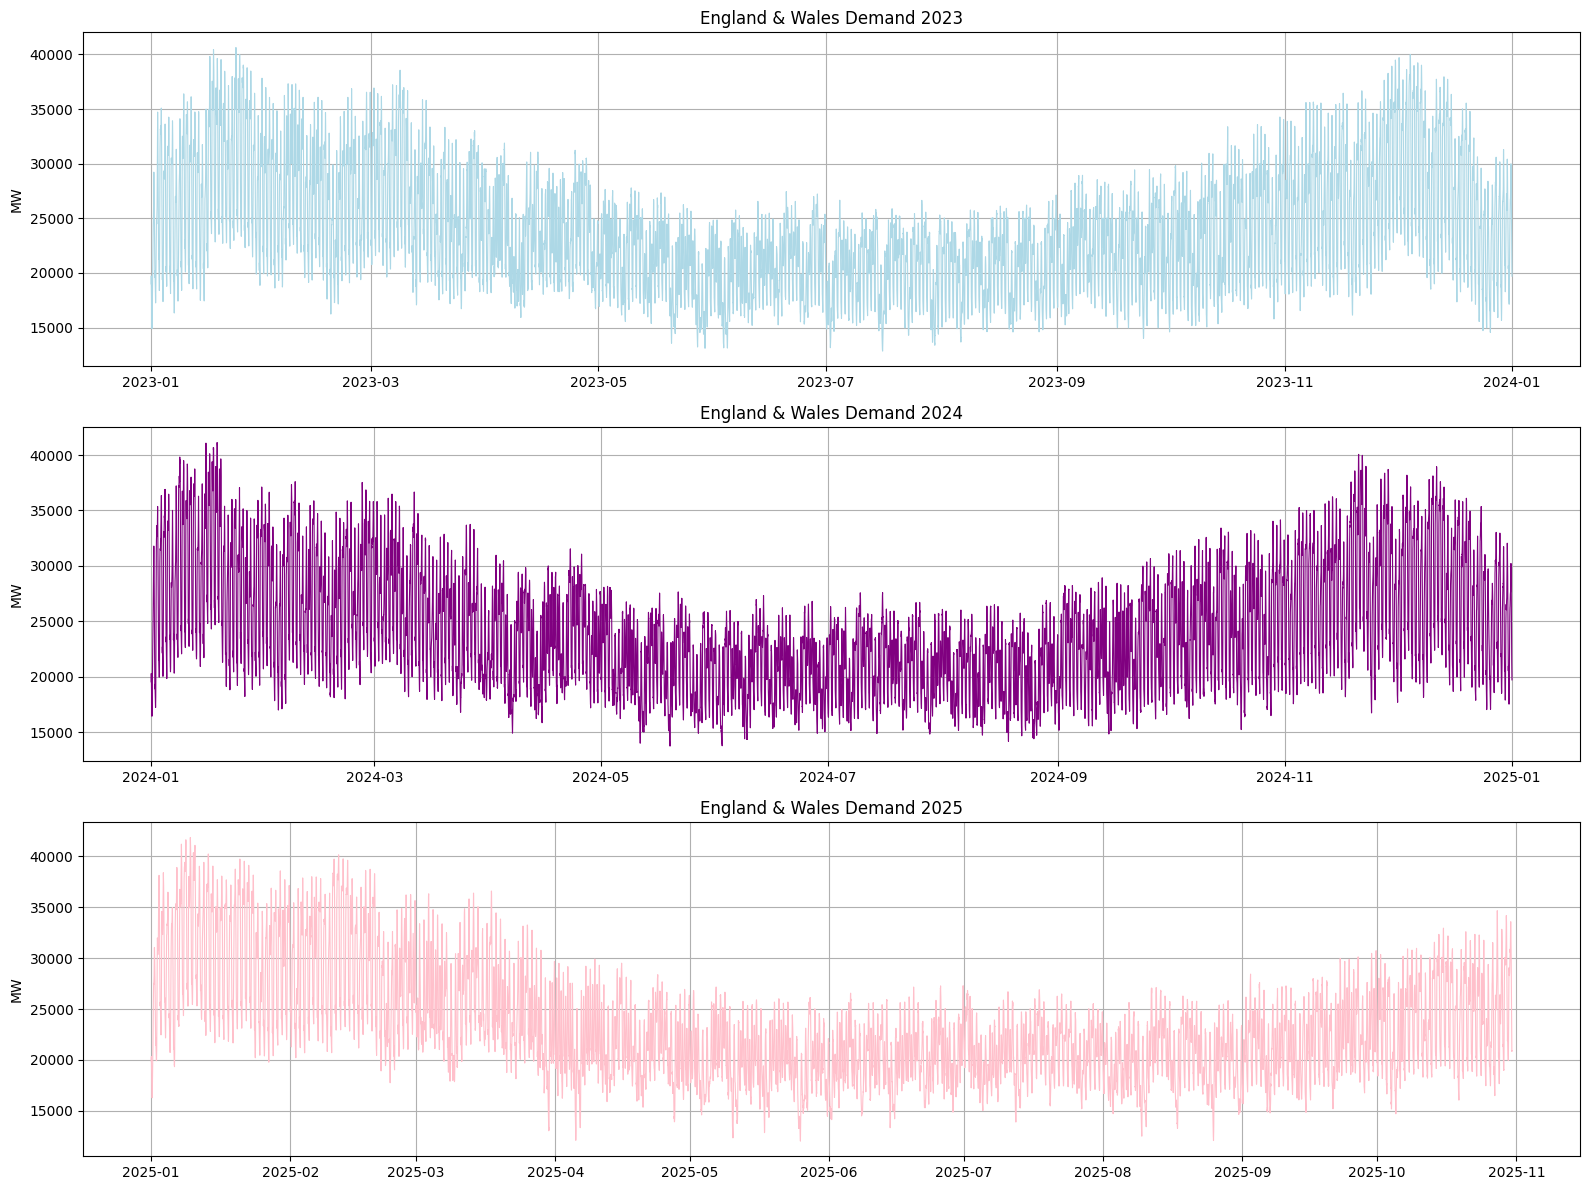

In [18]:
import matplotlib.pyplot as plt

df_2023=df[df['datetime'].dt.year==2023]
df_2024=df[df['datetime'].dt.year==2024]
df_2025=df[df['datetime'].dt.year==2025]

fig,axes=plt.subplots(3,1,figsize=(16,12))

#2023
axes[0].plot(df_2023['datetime'],df_2023['ENGLAND_WALES_DEMAND'],color='lightblue', linewidth=0.8)
axes[0].set_title('England & Wales Demand 2023')
axes[0].set_xlabel('')
axes[0].set_ylabel('MW')
axes[0].grid(True)

#2024
axes[1].plot(df_2024['datetime'],df_2024['ENGLAND_WALES_DEMAND'],color='purple', linewidth=0.8)
axes[1].set_title('England & Wales Demand 2024')
axes[1].set_xlabel('')
axes[1].set_ylabel('MW')
axes[1].grid(True)

#2025
axes[2].plot(df_2025['datetime'],df_2025['ENGLAND_WALES_DEMAND'],color='pink', linewidth=0.8)
axes[2].set_title('England & Wales Demand 2025')
axes[2].set_xlabel('')
axes[2].set_ylabel('MW')
axes[2].grid(True)

plt.tight_layout()
plt.show()

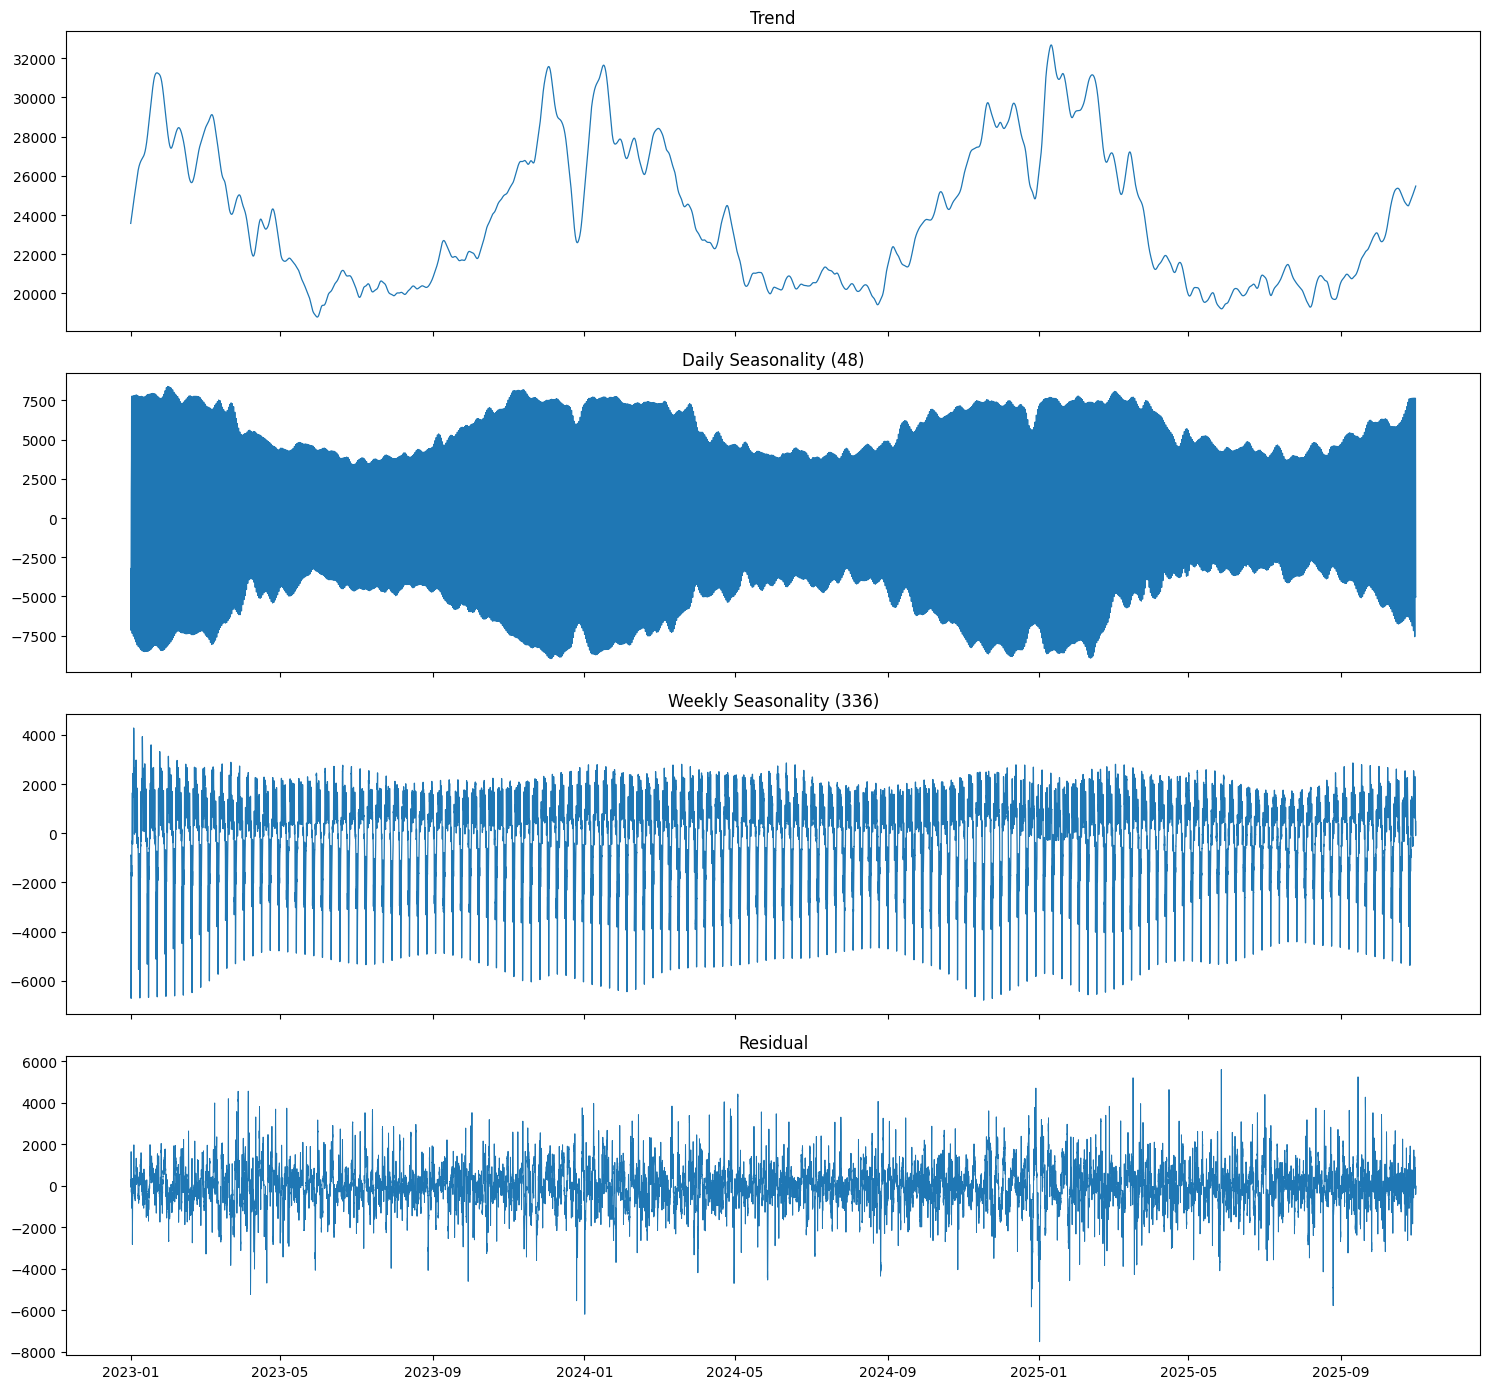

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import MSTL


df['datetime'] = pd.to_datetime(df['datetime'], utc=True, errors='coerce')
df['datetime'] = df['datetime'].dt.tz_localize(None)
df = df.set_index('datetime')



ts = df['ENGLAND_WALES_DEMAND']

mstl = MSTL(
    ts,
    periods=[48, 336],
    stl_kwargs={
        "seasonal_deg": 1,
        "trend_deg": 1,
        "trend_jump": 5
    }
)

res = mstl.fit()


trend = res.trend
seasonal_daily = res.seasonal['seasonal_48']
seasonal_weekly = res.seasonal['seasonal_336']
residual = res.resid


fig, axes = plt.subplots(4, 1, figsize=(15, 14), sharex=True)

axes[0].plot(trend, linewidth=0.9)
axes[0].set_title('Trend')

axes[1].plot(seasonal_daily, linewidth=0.9)
axes[1].set_title('Daily Seasonality (48)')

axes[2].plot(seasonal_weekly, linewidth=0.9)
axes[2].set_title('Weekly Seasonality (336)')

axes[3].plot(residual, linewidth=0.7)
axes[3].set_title('Residual')

plt.tight_layout()
plt.show()

In [20]:
# 5. plot seasonal patterns
# demand by time of day
# demand by day of week
# demand by month of year
# to identify regular fluctuations in demand associated with daily routines, weekly work patterns, seasonal changes

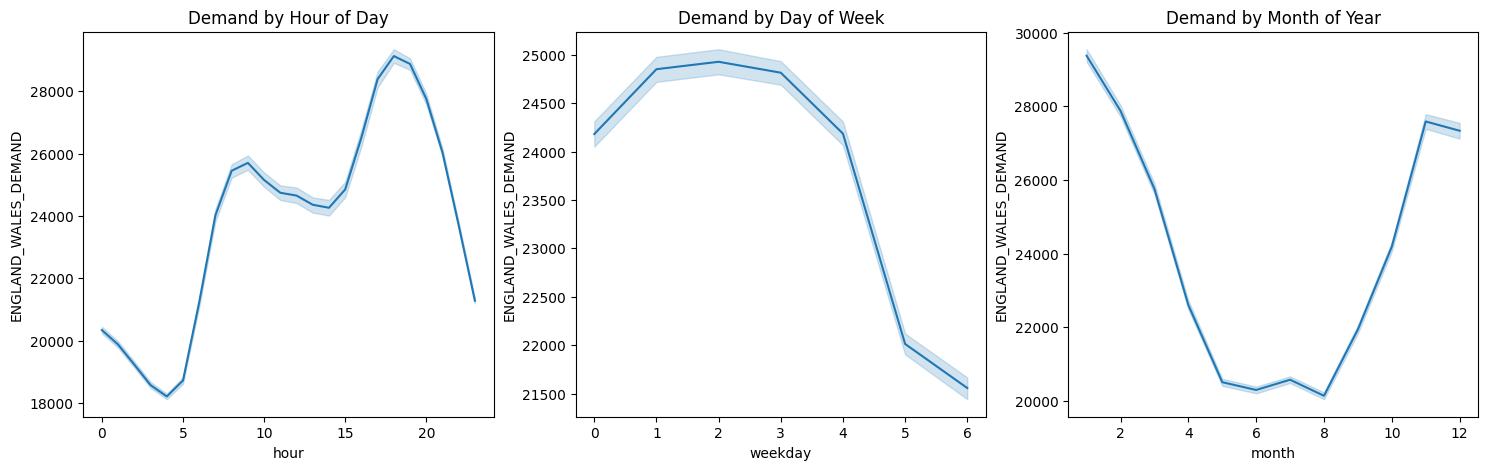

In [21]:
fig,axes=plt.subplots(1,3,figsize=(18,5))
sns.lineplot(data=df,x='hour',y='ENGLAND_WALES_DEMAND',ax=axes[0])
axes[0].set_title('Demand by Hour of Day')
sns.lineplot(data=df,x='weekday',y='ENGLAND_WALES_DEMAND',ax=axes[1])
axes[1].set_title('Demand by Day of Week')
sns.lineplot(data=df,x='month',y='ENGLAND_WALES_DEMAND',ax=axes[2])
axes[2].set_title('Demand by Month of Year')
plt.tight_layout
plt.show()

In [22]:
# 6. plot weather vs demand
# scatter plots of temperature, wind speed, solar radiation vs ENGLAND_WALES_DEMAND
# to identify relationships between weather conditions and energy demand patterns

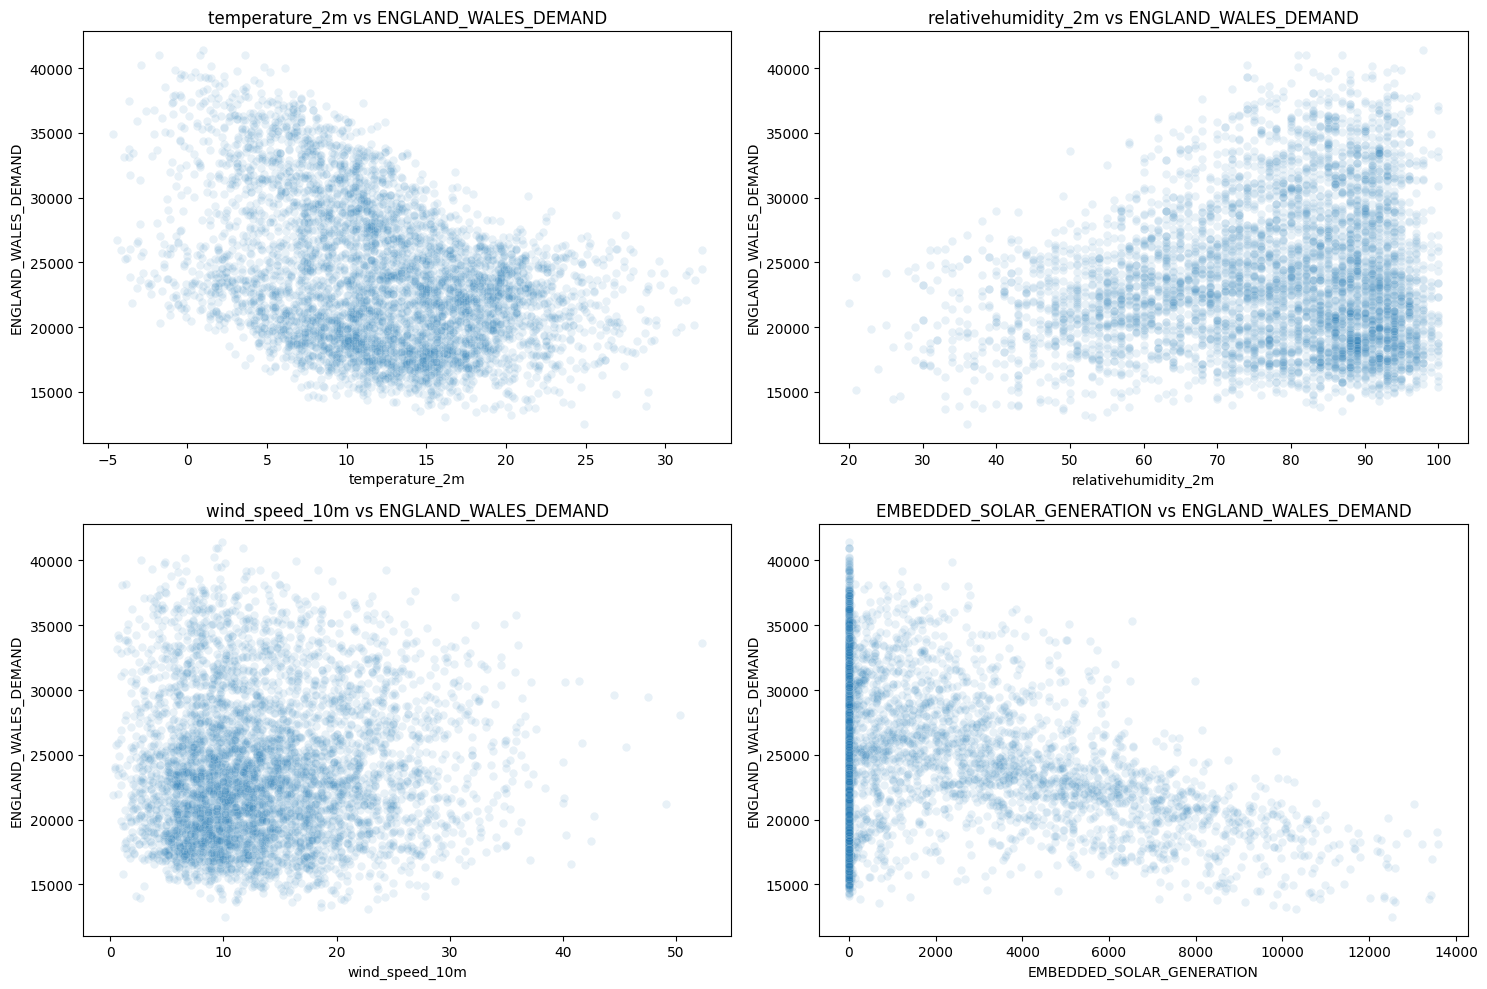

In [23]:
weather_vars= ['temperature_2m','relativehumidity_2m','wind_speed_10m', 'EMBEDDED_SOLAR_GENERATION']
fig,axes=plt.subplots(2,2,figsize=(15,10))
axes=axes.flatten()
for i,col in enumerate(weather_vars):
    sns.scatterplot(data=df.iloc[::10],x=col,y='ENGLAND_WALES_DEMAND',alpha=0.1,ax=axes[i])
    axes[i].set_title(f'{col} vs ENGLAND_WALES_DEMAND')
plt.tight_layout()
plt.show()


In [24]:
# 7. summary statistics
# mean, median, stddev, min, max of key variables
# to understand central tendencies and variability in energy demand and weather conditions

In [25]:
# Select key variables
key_vars = [
    "ENGLAND_WALES_DEMAND",
    "EMBEDDED_WIND_GENERATION",
    "EMBEDDED_SOLAR_GENERATION",
    "NON_BM_STOR",
    "temperature_2m",
    "relativehumidity_2m",
    "pressure_msl",
    "wind_speed_10m",
    "wind_direction_10m",
    "precipitation"
]

# Filter only variables that actually exist in the dataframe
key_vars = [v for v in key_vars if v in df.columns]

# Compute summary statistics
summary = df[key_vars].agg(["mean", "median", "std", "min", "max"]).T   # .T --> transpose

# Print Summary
print("\nSummary Statistics (Mean, Median, Standard Deviation, Min, Max):\n")
print(summary.round(2))


Summary Statistics (Mean, Median, Standard Deviation, Min, Max):

                               mean   median      std      min      max
ENGLAND_WALES_DEMAND       23791.38  22891.0  5472.45  12040.0  41835.0
EMBEDDED_WIND_GENERATION    1839.09   1516.0  1191.31    125.0   5962.0
EMBEDDED_SOLAR_GENERATION   1809.79     18.0  2786.53      0.0  14035.0
NON_BM_STOR                    0.00      0.0     0.01      0.0      2.0
temperature_2m                12.20     12.0     6.19     -5.0     33.6
relativehumidity_2m           77.14     81.0    15.47     17.0    100.0
pressure_msl                1014.83   1015.8    11.46    953.8   1046.0
wind_speed_10m                13.69     12.3     7.28      0.0     52.3
wind_direction_10m           190.12    218.0    92.03      1.0    360.0
precipitation                  0.09      0.0     0.35      0.0      9.7


In [26]:
# 8.distribution plots
# histograms/kde plots of ENGLAND_WALES_DEMAND, temperature, wind speed, solar radiation
# to visualize data distributions and identify skewness, kurtosis, outliers

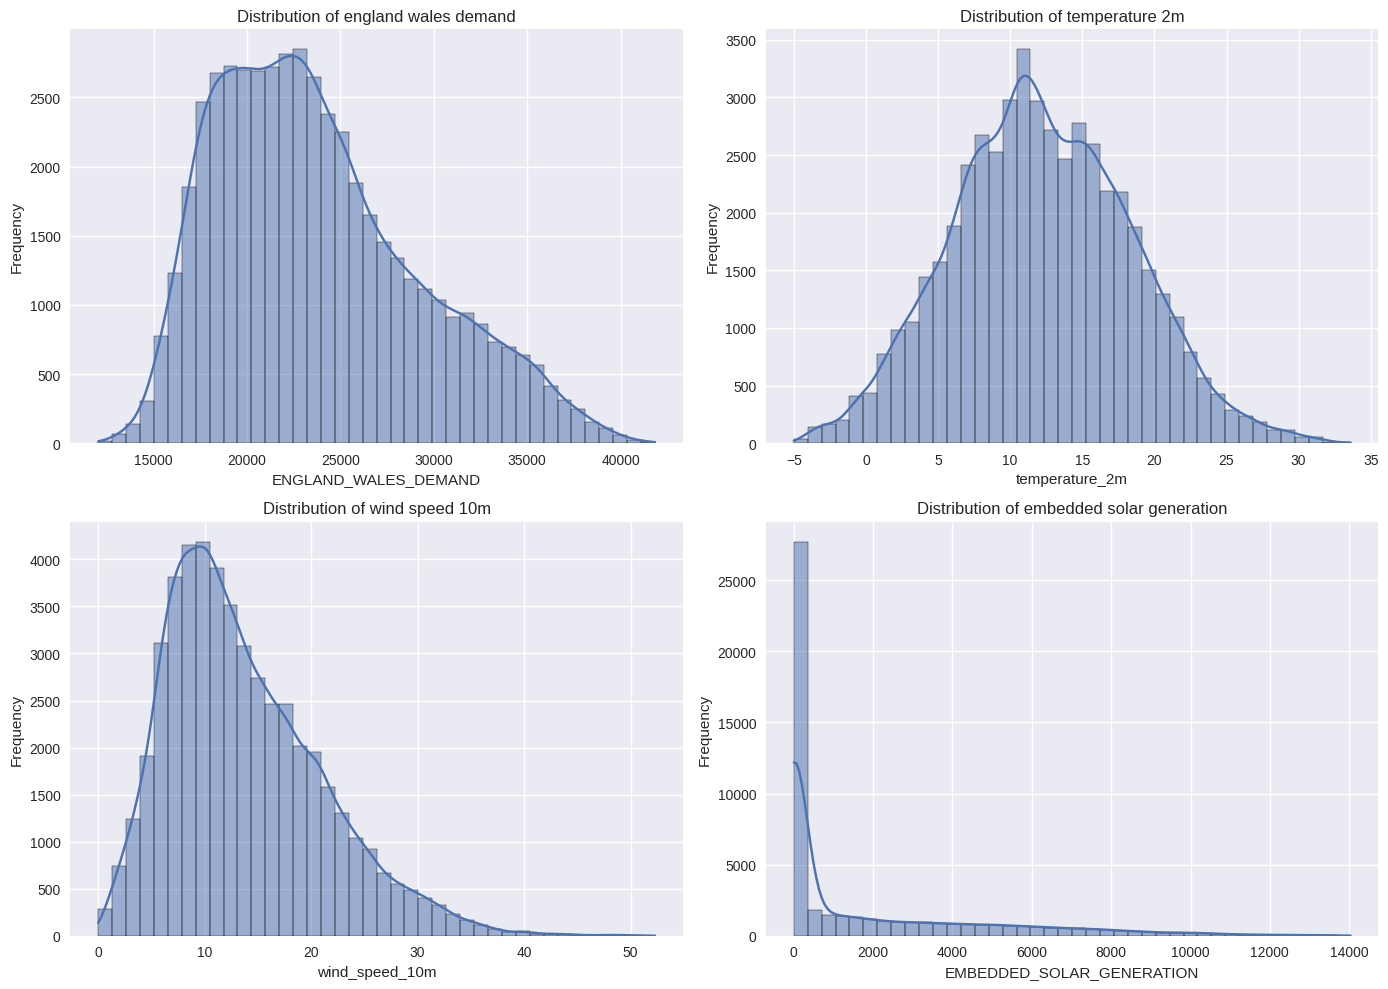

In [27]:
# Select variables for distribution plots
dist_vars = [
    "ENGLAND_WALES_DEMAND",
    "temperature_2m",
    "wind_speed_10m",
    "EMBEDDED_SOLAR_GENERATION"   # using solar generation as solar radiation proxy
]

# Plot settings
plt.style.use("seaborn-v0_8")
plt.figure(figsize=(14, 10))

for i, var in enumerate(dist_vars, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[var].dropna(), kde=True, bins=40)
    var_name = var.replace("_", " ").lower()
    plt.title(f"Distribution of {var_name}")
    plt.xlabel(var)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [28]:
# 9. box plots
# box plots of ENGLAND_WALES_DEMAND by month
# to identify monthly variations and outliers in demand patterns

# wq:nid 1 or 3 box plot? cuz around 3 years

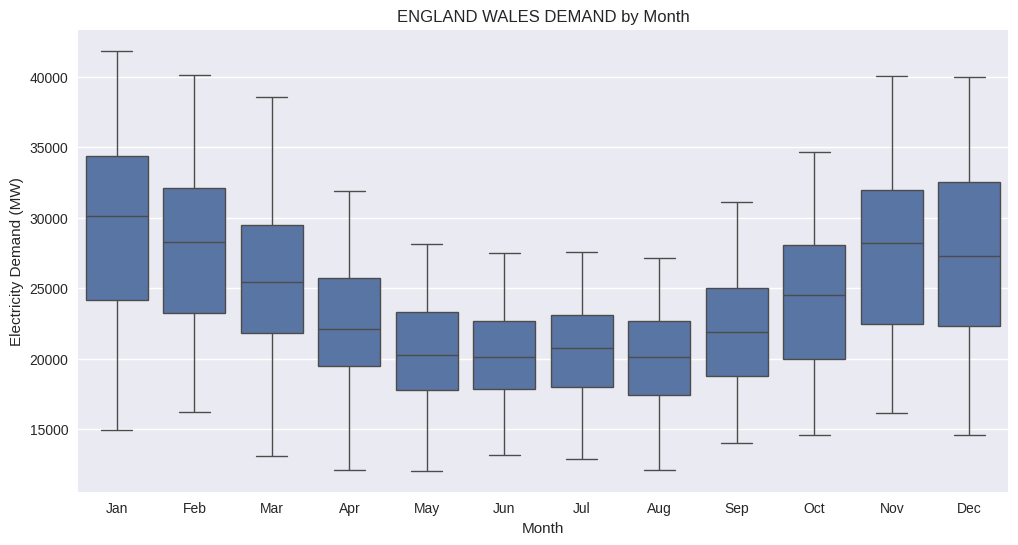

In [29]:
# Ensure your datetime column is in datetime format
# df['datetime'] = pd.to_datetime(df['datetime'])

# Extract month from datetime
# df['month'] = df.index.month


# Set plot style
# plt.style.use("seaborn-v0_8")
plt.figure(figsize=(12, 6))

# Create box plot
sns.boxplot(x='month', y='ENGLAND_WALES_DEMAND', data=df)
plt.title('ENGLAND WALES DEMAND by Month')
plt.xlabel('Month')
plt.ylabel('Electricity Demand (MW)')
plt.xticks(ticks=range(12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.show()

In [30]:
# 10. correlation
# check pearson correlation between Demand and weather variables

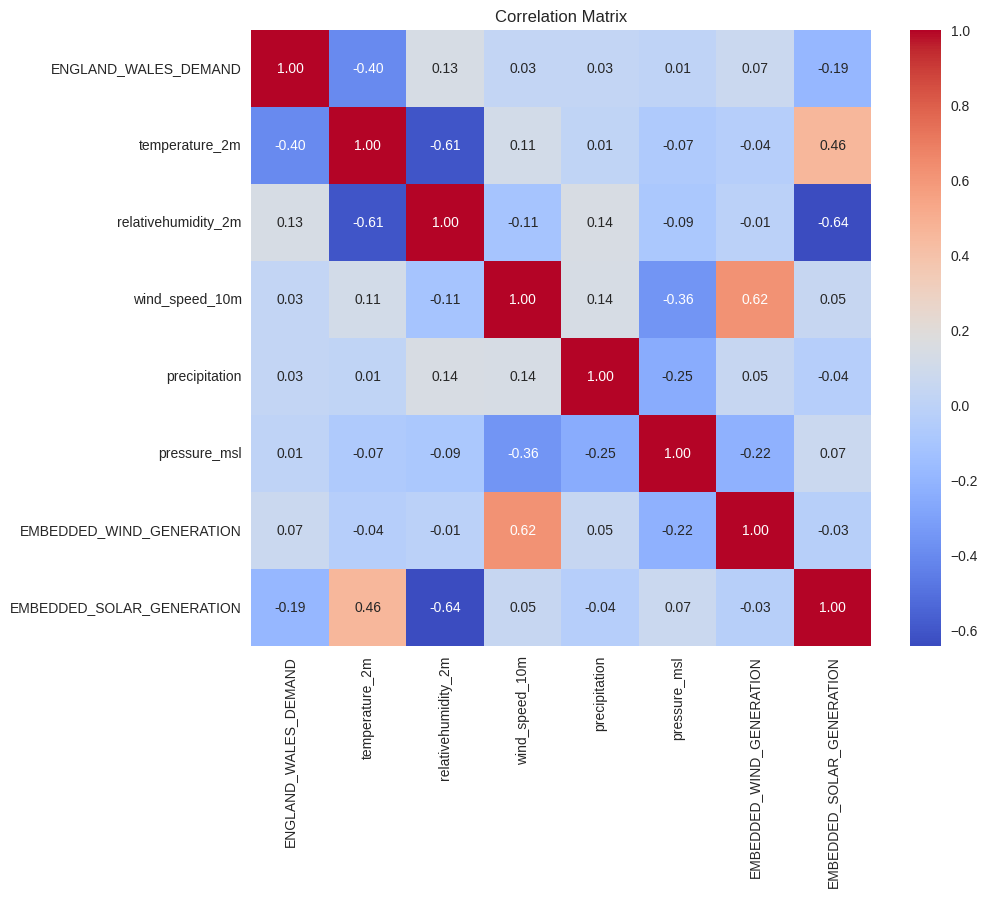

In [31]:
corr_cols=['ENGLAND_WALES_DEMAND','temperature_2m','relativehumidity_2m','wind_speed_10m','precipitation','pressure_msl','EMBEDDED_WIND_GENERATION','EMBEDDED_SOLAR_GENERATION']
plt.figure(figsize=(10,8))
sns.heatmap(df[corr_cols].corr(),annot=True,cmap='coolwarm',fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [32]:
# 11. stationarity check
# to determine if the time series data (e.g., ENGLAND_WALES_DEMAND) is stationary, which is important for time series modeling
# using ADF test or KPSS test
# rolling mean and stddev plots

In [33]:
from statsmodels.tsa.stattools import adfuller
series=df['ENGLAND_WALES_DEMAND'].dropna()
result=adfuller(series.iloc[:10000],autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is non-stationary.")

ADF Statistic: -2.8289607068160394
p-value: 0.054254533866952684
The time series is non-stationary.


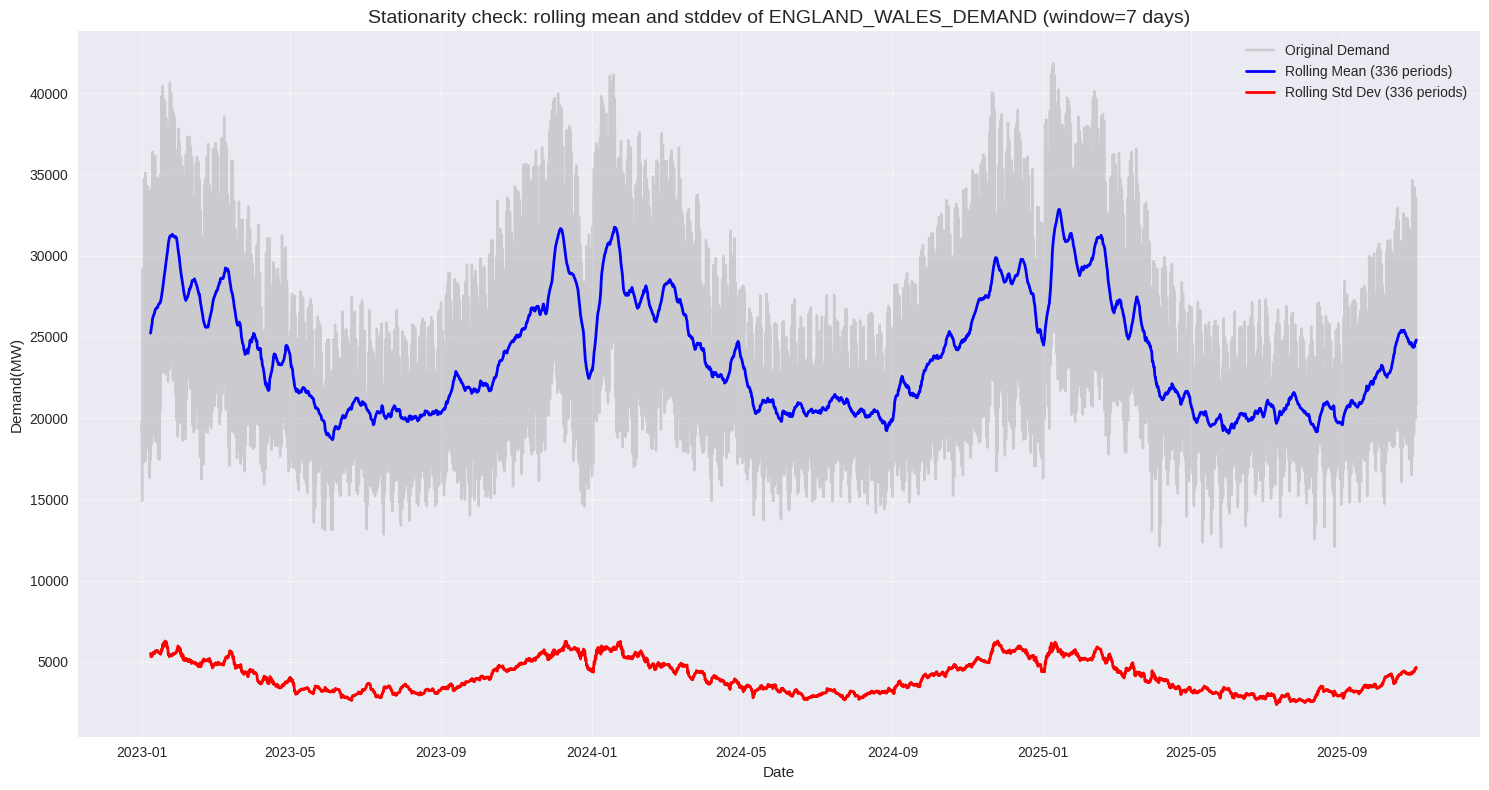

#remark
1.trend:if the blue line(rolling mean) shows a consistent upward or downward slope over time, it indicates a trend in the data.
2.variance:if red line(rolling std) increases or decreases over time, series has changing variance(heteroscedasticity/non stationary)
3.seasonality:repeating waves in rolling mean indicate seasonality


In [34]:
target_col='ENGLAND_WALES_DEMAND'
window_size=48*7  # one week of half-hourly data

if 'datetime' not in df.columns:
    df = df.reset_index()

rolling_mean=df[target_col].rolling(window=window_size).mean()
rolling_std=df[target_col].rolling(window=window_size).std()


plt.figure(figsize=(15,8))
plt.plot(df['datetime'],df[target_col], label='Original Demand', alpha=0.3,color='gray')
plt.plot(df['datetime'],rolling_mean, label=f'Rolling Mean ({window_size} periods)', color='blue',linewidth=2)
plt.plot(df['datetime'],rolling_std, label=f'Rolling Std Dev ({window_size} periods)', color='red',linewidth=2)
plt.title(f'Stationarity check: rolling mean and stddev of {target_col} (window=7 days)',fontsize=14)
plt.xlabel('Date')
plt.ylabel('Demand(MW)')
plt.legend(loc='best')
plt.grid(True,which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
print("#remark")
print("1.trend:if the blue line(rolling mean) shows a consistent upward or downward slope over time, it indicates a trend in the data.")
print("2.variance:if red line(rolling std) increases or decreases over time, series has changing variance(heteroscedasticity/non stationary)")
print("3.seasonality:repeating waves in rolling mean indicate seasonality")

# Part A

## Train Test Split

In [43]:

target = 'ENGLAND_WALES_DEMAND'

# Features
time_features = ['hour', 'day', 'month','year','is_weekend','weekday']
weather_features = ['temperature_2m', 'relativehumidity_2m', 'pressure_msl',
                    'wind_speed_10m', 'wind_direction_10m', 'precipitation']
grid_features = [
    'EMBEDDED_WIND_GENERATION', 'EMBEDDED_WIND_CAPACITY',
    'EMBEDDED_SOLAR_GENERATION', 'EMBEDDED_SOLAR_CAPACITY',
    'NON_BM_STOR', 'PUMP_STORAGE_PUMPING', 'SCOTTISH_TRANSFER',
    'IFA_FLOW', 'IFA2_FLOW', 'BRITNED_FLOW', 'MOYLE_FLOW',
    'EAST_WEST_FLOW', 'NEMO_FLOW', 'NSL_FLOW', 'ELECLINK_FLOW',
    'VIKING_FLOW', 'GREENLINK_FLOW'
]

feature_cols = weather_features + time_features + grid_features

model_df = df.dropna(subset=feature_cols + [target]).copy()

# split based on the date time
# 2023, 2024 -> train
train_df = model_df[model_df.year.isin([2023, 2024])].sort_values("datetime")
print(train_df.head())

# 2025 -> test
test_df = model_df[model_df.year == 2025].sort_values("datetime")
print(test_df.head())

# train set
X_train = train_df[feature_cols]
y_train = train_df[target]

# test set
X_test = test_df[feature_cols]
y_test = test_df[target]

print(f"Train Set: {X_train.shape}")
print(f"Test Set: {X_test.shape}")


             datetime           SETTLEMENT_DATE  SETTLEMENT_PERIOD     ND  \
0 2023-01-01 00:00:00 2023-01-01 00:00:00+00:00                  1  21043   
1 2023-01-01 00:30:00 2023-01-01 00:00:00+00:00                  2  21756   
2 2023-01-01 01:00:00 2023-01-01 00:00:00+00:00                  3  21348   
3 2023-01-01 01:30:00 2023-01-01 00:00:00+00:00                  4  20586   
4 2023-01-01 02:00:00 2023-01-01 00:00:00+00:00                  5  19781   

     TSD  ENGLAND_WALES_DEMAND  EMBEDDED_WIND_GENERATION  \
0  24680                 18995                      2815   
1  25289                 19730                      2793   
2  25269                 19327                      2773   
3  24574                 18589                      2753   
4  24135                 17806                      2712   

   EMBEDDED_WIND_CAPACITY  EMBEDDED_SOLAR_GENERATION  EMBEDDED_SOLAR_CAPACITY  \
0                    6545                          0                    15037   
1             

## Scaling

In [44]:
#Scaling
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled  = scaler_y.transform(y_test.values.reshape(-1,1))


## Create Sequences for LSTM

In [45]:
def create_sequences(X, y, timesteps):
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        X_seq.append(X[i:i+timesteps])
        y_seq.append(y[i+timesteps])
    return np.array(X_seq), np.array(y_seq)


## Neural classes

In [46]:
# Neural classes (MLP, LSTM_Model, TemporalCNN)
class MLP:
    def __init__(self, input_shape, epochs=50, batch_size=32):
        self.input_shape=input_shape
        self.epochs=epochs
        self.batch_size=batch_size
        self.model=self.build_model()

    def build_model(self):
        model=Sequential()
        model.add(Dense(32,activation='relu', input_shape=self.input_shape))
        model.add(Dense(1))
        model.compile(optimizer='adam',loss='mse')
        return model

    def fit_predict(self,X_train,y_train,X_test):
        start_train=time.time()
        self.model.fit(X_train,y_train,epochs=self.epochs,batch_size=self.batch_size,verbose=0)
        end_train=time.time()
        training_time=end_train-start_train

        start_pred=time.time()
        y_pred=self.model.predict(X_test).flatten()
        end_pred=time.time()
        inference_time=(end_pred - start_pred) / X_test.shape[0]

        return y_pred, training_time, inference_time

    def get_model_size(self):
        temp_path = "temp_mlp_model.keras"
        self.model.save(temp_path)
        size_mb = os.path.getsize(temp_path) / 1e6
        os.remove(temp_path)
        return size_mb

class LSTM_Model:
    def __init__(self,input_shape, epochs=50,batch_size=32):
        self.input_shape=input_shape
        self.epochs=epochs
        self.batch_size=batch_size
        self.model=self.build_model()

    def build_model(self):
        model=Sequential()
        model.add(LSTM(50,activation='tanh',input_shape=self.input_shape))
        model.add(Dense(1))
        model.compile(optimizer='adam',loss='mse')
        return model

    def fit_predict(self,X_train,y_train,X_test):
        start_train=time.time()
        self.model.fit(X_train,y_train, epochs=self.epochs,batch_size=self.batch_size,verbose=0)
        end_train=time.time()
        training_time=end_train-start_train

        start_pred=time.time()
        y_pred=self.model.predict(X_test)
        end_pred=time.time()
        inference_time = (end_pred - start_pred) / X_test.shape[0]

        return y_pred,training_time,inference_time

    def get_model_size(self):
        temp_path="temp_lstm_model.keras"
        self.model.save(temp_path)
        size_mb=os.path.getsize(temp_path)/1e6
        os.remove(temp_path)
        return size_mb

class TemporalCNN:
    def __init__(self, input_shape, epochs=50, batch_size=32):
        self.input_shape = input_shape
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()
        model.add(Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=self.input_shape))
        model.add(Conv1D(filters=16, kernel_size=1, activation='relu'))
        model.add(Flatten())
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        return model

    def fit_predict(self,X_train,y_train,X_test):
        start_train = time.time()
        self.model.fit(X_train, y_train, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        end_train = time.time()
        training_time = end_train - start_train

        start_pred = time.time()
        y_pred = self.model.predict(X_test).flatten()
        end_pred = time.time()
        inference_time = (end_pred - start_pred) / X_test.shape[0]  # per sample

        return y_pred, training_time, inference_time

    def get_model_size(self):
        temp_path = "temp_temporal_cnn.keras"
        self.model.save(temp_path)
        size_mb = os.path.getsize(temp_path) / 1e6
        os.remove(temp_path)
        return size_mb


## Helper function for evaluation

In [47]:
#Helper metrics & small utilities (for tables/diagnostics)
def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2, "MAPE": mape}

def pack_result_row(model_name, metrics_dict, train_time, inference_time, model):
    # compute model size inside here (consistent, no separate function)
    with tempfile.NamedTemporaryFile(delete=False) as tmp:
        joblib.dump(model, tmp.name)
        size_mb = os.path.getsize(tmp.name) / (1024 * 1024)
    os.remove(tmp.name)

    row = {"Model": model_name}
    row.update(metrics_dict)
    row.update({
        "Training Time (s)": train_time,
        "Inference Time per Sample (s)": inference_time,
        "Model Size (MB)": size_mb
    })
    return row


## Train model function

In [48]:
def train_model(
    X_test, y_test,
    X_train, y_train,
    X_test_scaled, X_train_scaled,
    y_train_scaled, scaler_y,
    scale=True
):
    models = {
        "Linear Regression": LinearRegression(),
        "SVR": LinearSVR(max_iter=5000),
        "Ridge Regression": Ridge(alpha=1.0),
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "XGBoost": XGBRegressor(
            n_estimators=100,
            random_state=42,
            n_jobs=-1,
            tree_method=XGBOOST_TREE_METHOD
        ),
        "Random Forest": RandomForestRegressor(
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        ),
        "MLP": "MLP",
        "Temporal CNN": "Temporal CNN"
    }

    results_list = []
    predictions = {}
    models_dict = {}

    for name, model in models.items():
        print(f"\n===== Training {name} =====")

        # Classical ML
        if name not in ["MLP", "Temporal CNN"]:
            start_train = time.time()
            model.fit(X_train, y_train)
            train_time = time.time() - start_train

            start_pred = time.time()
            y_pred = model.predict(X_test)
            inference_time = (time.time() - start_pred) / len(X_test)

            model_size = None
            models_dict[name] = model

        # MLP
        elif name == "MLP":
            mlp = MLP(input_shape=(X_train_scaled.shape[1],))
            y_pred_scaled, train_time, inference_time = mlp.fit_predict(
                X_train_scaled, y_train_scaled, X_test_scaled
            )
            y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
            model_size = mlp.get_model_size()
            models_dict[name] = mlp

        # Temporal CNN
        elif name == "Temporal CNN":
            X_train_seq = X_train_scaled.reshape(len(X_train_scaled), 1, -1)
            X_test_seq  = X_test_scaled.reshape(len(X_test_scaled), 1, -1)

            cnn = TemporalCNN(input_shape=(1, X_train_scaled.shape[1]))
            y_pred_scaled, train_time, inference_time = cnn.fit_predict(
                X_train_seq, y_train_scaled, X_test_seq
            )
            y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
            model_size = cnn.get_model_size()
            models_dict[name] = cnn

        # Store predictions
        predictions[name] = y_pred

        # Compute metrics
        metrics = compute_metrics(y_test, y_pred)

        # Append uniform row
        results_list.append({
            "Model": name,
            **metrics,
            "Training Time (s)": train_time,
            "Inference Time per Sample (s)": inference_time,
            "Model Size (MB)": model_size
        })

    return predictions, results_list, models_dict


In [52]:
# LSTM training wrapper
def train_LSTM(
    predictions, results_list,
    X_train_raw, X_test_raw,
    y_train_raw, y_test_raw,
    scaler_y,
    timesteps=24, scale=True
):
    # Ensure inputs are numpy arrays for create_sequences
    X_train_np = X_train_raw if isinstance(X_train_raw, np.ndarray) else X_train_raw.to_numpy()
    X_test_np  = X_test_raw if isinstance(X_test_raw, np.ndarray) else X_test_raw.to_numpy()
    y_train_np = y_train_raw if isinstance(y_train_raw, np.ndarray) else y_train_raw.to_numpy()
    y_test_np  = y_test_raw if isinstance(y_test_raw, np.ndarray) else y_test_raw.to_numpy()

    # Create sequences
    X_train_seq, y_train_seq = create_sequences(X_train_np, y_train_np, timesteps)
    X_test_seq, y_test_seq   = create_sequences(X_test_np, y_test_np, timesteps)

    # Initialize LSTM model with correct input shape (timesteps, features)
    lstm = LSTM_Model(input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]))

    y_pred_scaled, train_time, inference_time = lstm.fit_predict(
        X_train_seq, y_train_seq, X_test_seq
    )

    # Inverse scale predictions
    y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()

    # Add prediction
    predictions["LSTM"] = y_pred

    # Inverse scale y_test_seq for metric computation if scaled
    # y_test_seq contains the actual values corresponding to the predictions made
    y_test_actual = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).flatten() if scale else y_test_seq

    # Compute metrics
    metrics = compute_metrics(y_test_actual, y_pred)

    results_list.append({
        "Model": "LSTM",
        **metrics,
        "Training Time (s)": train_time,
        "Inference Time per Sample (s)": inference_time,
        "Model Size (MB)": lstm.get_model_size()
    })

    return predictions, results_list


## A. Raw data training

In [53]:
# Part A - Step 1: Train on raw data (no preprocess)
XGBOOST_TREE_METHOD = 'hist'

# Use original X_train, X_test, y_train, y_test (no scaling)
predictions_raw, results_list_raw, models_dict_raw = train_model(
    X_test, y_test,
    X_train, y_train,
    X_test.to_numpy(), X_train.to_numpy(),
    y_train.to_numpy().reshape(-1, 1), scaler_y,
    False
)

# Add LSTM (no scaling)
predictions_raw, results_list_raw = train_LSTM(
    predictions_raw, results_list_raw,
    X_train.to_numpy(), X_test.to_numpy(), # Convert DataFrames to NumPy arrays
    y_train.to_numpy(), y_test.to_numpy(), # Convert Series to NumPy arrays
    scaler_y, timesteps=24, scale=False
)

result_table_1 = pd.DataFrame(results_list_raw)
print("Result Table 1 - Raw data (no preprocess):")
display(result_table_1)


===== Training Linear Regression =====

===== Training SVR =====


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



===== Training Ridge Regression =====

===== Training Decision Tree =====

===== Training XGBoost =====

===== Training Random Forest =====

===== Training MLP =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

===== Training Temporal CNN =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Result Table 1 - Raw data (no preprocess):


,Model,MAE,MSE,RMSE,R2,MAPE,Training Time (s),Inference Time per Sample (s),Model Size (MB)
0,Linear Regression,1.374217e+04,2.330029e+08,1.526443e+04,-6.870027e+00,0.651749,0.022763,1.686223e-07,NaN
1,SVR,5.750933e+03,4.542394e+07,6.739728e+03,-5.342629e-01,0.273460,28.310970,1.960458e-07,NaN
2,Ridge Regression,1.357505e+04,2.275412e+08,1.508447e+04,-6.685553e+00,0.643809,0.011632,1.751627e-07,NaN
3,Decision Tree,1.611441e+03,4.562386e+06,2.135974e+03,8.458985e-01,0.071195,1.196434,3.492107e-07,NaN
4,XGBoost,1.288682e+03,2.690370e+06,1.640235e+03,9.091287e-01,0.054946,0.243744,8.095249e-07,NaN
5,Random Forest,1.228089e+03,2.609699e+06,1.615456e+03,9.118534e-01,0.053947,9.941722,3.283341e-06,NaN
6,MLP,8.166662e+08,6.962276e+17,8.344025e+08,-2.351615e+10,36063.937500,83.833015,6.578125e-05,0.032793
7,Temporal CNN,8.580552e+08,8.001462e+17,8.945089e+08,-2.702616e+10,37914.062500,96.121366,7.775472e-05,0.045988
8,LSTM,2.552900e+07,6.518556e+14,2.553146e+07,-2.200721e+07,1153.287109,218.711215,8.208797e-05,0.216797


## B. Post preprocessing training

In [ ]:
# Part A - Step 2: Minimal preprocessing (outlier handling, scaling, simple transform, feature selection)

def iqr_clip_df(df_in, cols):
    df = df_in.copy()
    for c in cols:
        q1 = df[c].quantile(0.25)
        q3 = df[c].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        df[c] = df[c].clip(lower, upper)
    return df

# Apply IQR clipping to train_df (only features)
train_df_clipped = train_df.copy()
train_df_clipped[feature_cols] = iqr_clip_df(train_df_clipped[feature_cols], feature_cols)

# Re-derive X_train_minpreproc, y_train_minpreproc, X_test_minpreproc, y_test_minpreproc
X_train_min = train_df_clipped[feature_cols]
y_train_min = train_df_clipped[target]

# For test we keep original test_df (no leakage)
X_test_min = X_test.copy()
y_test_min = y_test.copy()

# Recompute scaling on this minimally preprocessed train if desired
X_train_min_scaled = scaler_X.transform(X_train_min)
X_test_min_scaled  = scaler_X.transform(X_test_min)
y_train_min_scaled = scaler_y.transform(y_train_min.values.reshape(-1,1))
y_test_min_scaled  = scaler_y.transform(y_test_min.values.reshape(-1,1))

# Train again using scaled flag True (so neural nets receive scaled arrays)
predictions_minpre, results_list_minpre, _ = train_model(
    X_test_min, y_test_min,
    X_train_min, y_train_min,
    X_test_min_scaled, X_train_min_scaled,
    y_train_min_scaled, scaler_y, True
)

predictions_minpre, results_list_minpre = train_LSTM(
    predictions_minpre, results_list_minpre,
    X_train_min_scaled, X_test_min_scaled,
    y_train_min_scaled, y_test_min_scaled,
    scaler_y, timesteps=24, scale=True
)

result_table_2 = pd.DataFrame(results_list_minpre)
print("Result Table 2 - Minimal preprocess (IQR clipping + scaling):")
display(result_table_2)



===== Training Linear Regression =====

===== Training SVR =====


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



===== Training Ridge Regression =====

===== Training Decision Tree =====

===== Training XGBoost =====

===== Training Random Forest =====

===== Training MLP =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

===== Training Temporal CNN =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## C. Evaluation with bias-variance tradeoff graph, model complexity vs error, ridge regularization graph

In [ ]:
# Part A - Step 3: Evaluation Tables 3-5 (Bias-Variance, Complexity vs Error, Ridge Regularization Impact)
# Bias-Variance diagnostics (train vs validation R^2, generalization gap)
def bias_variance_diagnostics(model, X_train, y_train, X_val, y_val):
    # Train model on full training set and evaluate on validation
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train, y_train)
    train_r2 = r2_score(y_train, model.predict(X_train))
    val_r2 = r2_score(y_val, model.predict(X_val))
    gen_gap = train_r2 - val_r2
    bias_indicator = "High bias" if train_r2 < 0.5 and val_r2 < 0.5 else "Low bias"
    variance_indicator = "High variance" if gen_gap > 0.1 else "Low variance"
    return {"Training R2": train_r2, "Validation R2": val_r2, "Bias indicator": bias_indicator,
            "Variance indicator": variance_indicator, "Generalization Gap": gen_gap}

# Build a small validation split from train for diagnostics
X_tr_sub, X_val_sub, y_tr_sub, y_val_sub = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

diag_rows = []
complexity_rows = []

# define models to check for diagnostics
diag_models = {
    "Linear Regression": LinearRegression(),
    "Linear SVR": LinearSVR(max_iter=5000),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=50, random_state=42, n_jobs=-1,
                            tree_method=XGBOOST_TREE_METHOD if XGBOOST_TREE_METHOD != 'auto' else 'hist'),
}

for name, mod in diag_models.items():
    d = bias_variance_diagnostics(mod, X_tr_sub, y_tr_sub, X_val_sub, y_val_sub)
    d_row = {"Model": name}
    d_row.update(d)
    diag_rows.append(d_row)

result_table_3 = pd.DataFrame(diag_rows)
print("Result Table 3 - Bias-Variance Diagnostics:")
display(result_table_3)

# Model-Complexity vs Error
# record simple complexity metrics: tree depth (for trees), number of params (approx) for linear models
def model_complexity_metrics(name, model):
    if isinstance(model, DecisionTreeRegressor):
        cm = {"Complexity metric": f"max_depth={getattr(model, 'max_depth', None)}"}
    elif isinstance(model, RandomForestRegressor):
        cm = {"Complexity metric": f"n_estimators={getattr(model, 'n_estimators', None)}"}
    elif isinstance(model, XGBRegressor):
        cm = {"Complexity metric": f"n_estimators={getattr(model, 'n_estimators', None)}"}
    else:
        cm = {"Complexity metric": "Default/Linear"}
    return cm

for name, mod in diag_models.items():
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        mod.fit(X_tr_sub, y_tr_sub)
    train_err = mean_squared_error(y_tr_sub, mod.predict(X_tr_sub))
    val_err = mean_squared_error(y_val_sub, mod.predict(X_val_sub))
    comp = model_complexity_metrics(name, mod)
    overfit_index = (train_err - val_err)
    complexity_rows.append({
        "Model": name,
        "Complexity metrics (short)": comp["Complexity metric"],
        "Train error": train_err,
        "Val error": val_err,
        "Overfitting Index": overfit_index
    })

result_table_4 = pd.DataFrame(complexity_rows)
print("Result Table 4 - Model-Complexity vs Error:")
display(result_table_4)

# Regularization Impact (Ridge Regression) - vary alpha and report train/val/test R2 + coef magnitude
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
ridge_rows = []
for a in alphas:
    r = Ridge(alpha=a)
    r.fit(X_train, y_train)
    train_r2 = r2_score(y_train, r.predict(X_train))
    val_r2 = r2_score(X_val_sub and y_val_sub and y_val_sub, r.predict(X_val_sub)) if False else r2_score(y_val_sub, r.predict(X_val_sub))
    test_r2 = r2_score(y_test, r.predict(X_test))
    coef_mag = np.mean(np.abs(r.coef_)) if hasattr(r, 'coef_') else None
    ridge_rows.append({"Alpha": a, "Train R²": train_r2, "Val R²": val_r2, "Test R²": test_r2, "Coefficient Magnitude": coef_mag})

result_table_5 = pd.DataFrame(ridge_rows)
print("Result Table 5 - Ridge Regularization Impact:")
display(result_table_5)


In [ ]:
# error analysis

In [ ]:
# feature importance

In [ ]:
from sklearn.inspection import permutation_importance

def ml_permutation_importance(model_dict, X_test, y_test, n_repeats=1, top_n=10, random_state=42):

    for model_name, model in model_dict.items():
        print(f"===== Permutation Importance: {model_name} =====")

        result = permutation_importance(
            model,
            X_test,
            y_test,
            n_repeats=n_repeats,
            random_state=random_state
        )

        importance = result.importances_mean
        sorted_idx = importance.argsort()[::-1][:top_n]

        plt.figure(figsize=(6, 4))
        plt.bar(
            X_test.columns[sorted_idx],
            importance[sorted_idx]
        )
        plt.xticks(rotation=45, ha="right")
        plt.title(f"Top {top_n} Permutation Importance: {model_name}")
        plt.tight_layout()
        plt.show()


In [ ]:
ml_permutation_importance(models_dict_scaled, X_test_scaled, y_test)

In [ ]:
import xgboost as xgb

xgb_model = models_dict_raw["XGBoost"]   # choose the correct model dict

xgb.plot_importance(
    xgb_model,
    max_num_features=20,
    importance_type="gain"
)

plt.title("XGBoost Feature Importance (Gain)")
plt.show()

In [ ]:
xgb_model = models_dict_scaled["XGBoost"]

In [ ]:
import shap

# select model
xgb_model = models_dict_raw["XGBoost"]

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

In [ ]:
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, X_test_scaled)

## D. 5-fold cv

In [ ]:
# Part A - Step 4: 5-fold cross validation table
def cross_val_summary(model, X, y, folds=5):
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    r2_scores = []
    mse_scores = []
    for train_idx, val_idx in kf.split(X):
        Xtr, Xv = X.iloc[train_idx], X.iloc[val_idx]
        ytr, yv = y.iloc[train_idx], y.iloc[val_idx]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(Xtr, ytr)
        preds = model.predict(Xv)
        r2_scores.append(r2_score(yv, preds))
        mse_scores.append(mean_squared_error(yv, preds))
    return {"Mean R2": np.mean(r2_scores), "Std R2": np.std(r2_scores),
            "Mean MSE": np.mean(mse_scores), "Std MSE": np.std(mse_scores)}

cv_models = {
    "Linear Regression": LinearRegression(),
    "Linear SVR": LinearSVR(max_iter=5000),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=50, random_state=42, n_jobs=-1,
                            tree_method=XGBOOST_TREE_METHOD if XGBOOST_TREE_METHOD != 'auto' else 'hist')
}

cv_rows = []
for name, mod in cv_models.items():
    summary = cross_val_summary(mod, X_train, y_train, folds=5)
    row = {"Model": name}
    row.update(summary)
    cv_rows.append(row)

result_table_6 = pd.DataFrame(cv_rows)
print("Result Table 6 - 5-fold Cross Validation Summary:")
display(result_table_6)


## Select winner models

In [ ]:
df_table1 = result_table_1.copy()
# Quick pick via lowest RMSE per category (simple heuristics):
# Regression models: Linear Regression, Linear SVR, Ridge Regression
regression_rows = df_table1[df_table1['Model'].isin(['Linear Regression','SVR','Ridge Regression'])]
winner_regression = regression_rows.sort_values('RMSE').iloc[0]['Model'] if not regression_rows.empty else None

tree_rows = df_table1[df_table1['Model'].isin(['Decision Tree','Random Forest','XGBoost'])]
winner_tree = tree_rows.sort_values('RMSE').iloc[0]['Model'] if not tree_rows.empty else None

neural_rows = df_table1[df_table1['Model'].isin(['MLP','LSTM','Temporal CNN'])]
winner_neural = neural_rows.sort_values('RMSE').iloc[0]['Model'] if not neural_rows.empty else None

print("Winner candidates (simple RMSE heuristic):")
print("Regression winner:", winner_regression)
print("Tree-based winner:", winner_tree)
print("Neural winner:", winner_neural)
